In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## 1. Load Data

In [2]:
data_folder = "/data/"
df = pd.read_csv(data_folder + "train.csv")
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [3]:
asset_details.sort_values(by='Asset_ID').set_index('Asset_ID')

,Weight,Asset_Name
Asset_ID,,
0,4.304065,Binance Coin
1,6.779922,Bitcoin
2,2.397895,Bitcoin Cash
3,4.406719,Cardano
4,3.555348,Dogecoin
5,1.386294,EOS.IO
6,5.894403,Ethereum
7,2.079442,Ethereum Classic
8,1.098612,IOTA


In [4]:
bnb = df[df['Asset_ID'] == 0]
btc = df[df['Asset_ID'] == 1]
bch = df[df['Asset_ID'] == 2]
ada = df[df['Asset_ID'] == 3]
doge = df[df['Asset_ID'] == 4]
eos = df[df['Asset_ID'] == 5]
eth = df[df['Asset_ID'] == 6]
etc = df[df['Asset_ID'] == 7]
iota = df[df['Asset_ID'] == 8]
ltc = df[df['Asset_ID'] == 9]
mkr = df[df['Asset_ID'] == 10]
xmr = df[df['Asset_ID'] == 11]
xlm = df[df['Asset_ID'] == 12]
trx = df[df['Asset_ID'] == 13]

In [5]:
total = [bnb, btc, bch, ada, doge, eos, eth, etc, iota, ltc, mkr, xmr, xlm, trx]
for id, crypto in enumerate(total):
    crypto.set_index('timestamp', inplace=True)
    start = crypto.index[0].astype('datetime64[s]')
    end = crypto.index[-1].astype('datetime64[s]')
    print('Asset_ID_' + str(id) + ': starts from', start, 'to', end)
    print()

Asset_ID_0: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_1: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_2: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_3: starts from 2018-04-17T09:11:00 to 2021-09-21T00:00:00

Asset_ID_4: starts from 2019-04-12T14:34:00 to 2021-09-21T00:00:00

Asset_ID_5: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_6: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_7: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_8: starts from 2018-05-09T08:07:00 to 2021-09-21T00:00:00

Asset_ID_9: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_10: starts from 2018-05-10T15:21:00 to 2021-09-21T00:00:00

Asset_ID_11: starts from 2018-01-01T00:01:00 to 2021-09-21T00:00:00

Asset_ID_12: starts from 2018-02-16T23:53:00 to 2021-09-21T00:00:00

Asset_ID_13: starts from 2018-02-06T21:37:00 to 2021-09-21T00:00:00



In [6]:
fill_method = 'nearest'

# fills na with forward fill
def fill_missing_value(data, fill_method):
#     data.set_index('timestamp', inplace=True)
    timeframe = range(data.index[0], data.index[-1]+60, 60)
    data = data.reindex(timeframe, method=fill_method)
    # check NAs after filled index and using fill_method
    # print('Original missing values:', len(data[data.isna().any(axis=1)]))
    data['Target'] = data['Target'].fillna(method='pad')
    if data.isnull().values.any():
        data['Target'] = data['Target'].fillna(method='bfill')
    # check if filled all NAs
    print('Remaining missing:', len(data[data.isna().any(axis=1)]))
    print()
    return data

In [7]:
# fill missing values for cryptos that starts at 2018-01-01 
bnb = fill_missing_value(bnb, fill_method)
btc = fill_missing_value(btc, fill_method)
bch = fill_missing_value(bch, fill_method)
eos = fill_missing_value(eos, fill_method)
eth = fill_missing_value(eth, fill_method)
etc = fill_missing_value(etc, fill_method)
ltc = fill_missing_value(ltc, fill_method)
xmr = fill_missing_value(xmr, fill_method)

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0



In [8]:
# fill missing values for cryptos that starts after 2018-01-01 
ada = fill_missing_value(ada, fill_method)
doge = fill_missing_value(doge, fill_method)
iota = fill_missing_value(iota, fill_method)
mkr = fill_missing_value(mkr, fill_method)
xlm = fill_missing_value(xlm, fill_method)
trx = fill_missing_value(trx, fill_method)

Remaining missing: 0

Remaining missing: 0

Remaining missing: 0

Remaining missing: 18

Remaining missing: 0

Remaining missing: 0



In [9]:
# lets use bnb, btc, bch, eos, eth, etc, ltc, ada, trx
# use the latest start date among above cryptos 2018-04-17T09:11:00 
# timestamp 1523956260

start_date = 1523956260

# function that truncate data
def data_slicing(data, start_date):
    dat = data.reset_index()
    start_index = int(dat[dat['timestamp'] == start_date].index.values)
    dat = data[start_index:]
    # dat.set_index('timestamp', inplace=True)
    # print(len(dat))
    return dat

In [10]:
bnb = data_slicing(bnb, start_date)
btc = data_slicing(btc, start_date)
bch = data_slicing(bch, start_date)
eos = data_slicing(eos, start_date)
eth = data_slicing(eth, start_date)
etc = data_slicing(etc, start_date)
ltc = data_slicing(ltc, start_date)
ada = data_slicing(ada, start_date)
trx = data_slicing(trx, start_date)

In [11]:
# check cross-asset correlations in close price, volume, target return
# close price
dat_close = {'bnb': bnb['Close'], 'btc': btc['Close'], 'bch': bch['Close'], 'eos': eos['Close'], 
             'eth': eth['Close'], 'etc': etc['Close'], 'ltc': ltc['Close'], 'ada': ada['Close'],
             'trx': trx['Close']}

# volume
dat_volume = {'bnb': bnb['Volume'], 'btc': btc['Volume'], 'bch': bch['Volume'], 'eos': eos['Volume'], 
              'eth': eth['Volume'], 'etc': etc['Volume'], 'ltc': ltc['Volume'], 'ada': ada['Volume'],
              'trx': trx['Volume']}

# target
dat_target = {'bnb': bnb['Target'], 'btc': btc['Target'], 'bch': bch['Target'], 'eos': eos['Target'], 
              'eth': eth['Target'], 'etc': etc['Target'], 'ltc': ltc['Target'], 'ada': ada['Target'],
              'trx': trx['Target']}

close_agg = pd.DataFrame(data=dat_close)
volume_agg = pd.DataFrame(data=dat_volume)
target_agg = pd.DataFrame(data=dat_target)

In [12]:
# close price correlation
close_agg.corr(method='pearson')

,bnb,btc,bch,eos,eth,etc,ltc,ada,trx
bnb,1.000000,0.884862,0.458355,0.166197,0.947988,0.857244,0.842464,0.928532,0.881422
btc,0.884862,1.000000,0.409546,0.074662,0.905660,0.658520,0.874905,0.856582,0.785488
bch,0.458355,0.409546,1.000000,0.896951,0.527892,0.578763,0.704028,0.457224,0.736777
eos,0.166197,0.074662,0.896951,1.000000,0.219714,0.339155,0.465816,0.181592,0.533962
eth,0.947988,0.905660,0.527892,0.219714,1.000000,0.890923,0.856814,0.967143,0.870005
etc,0.857244,0.658520,0.578763,0.339155,0.890923,1.000000,0.722331,0.868205,0.795402
ltc,0.842464,0.874905,0.704028,0.465816,0.856814,0.722331,1.000000,0.777042,0.897286
ada,0.928532,0.856582,0.457224,0.181592,0.967143,0.868205,0.777042,1.000000,0.824226
trx,0.881422,0.785488,0.736777,0.533962,0.870005,0.795402,0.897286,0.824226,1.000000


<AxesSubplot:>

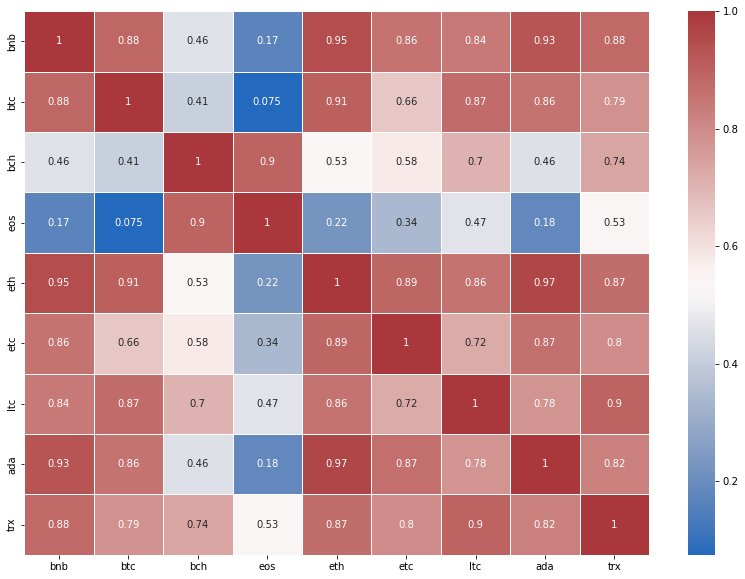

In [13]:
# close price correlation
plt.figure(figsize=(14, 10))
sns.heatmap(close_agg.corr(method='pearson'),  
            cmap='vlag', 
            annot=True, 
            linewidth=0.5)

In [14]:
# volume correlation
volume_agg.corr(method='pearson')

,bnb,btc,bch,eos,eth,etc,ltc,ada,trx
bnb,1.000000,0.344598,0.318429,0.300058,0.354095,0.034521,0.319474,0.284698,0.276284
btc,0.344598,1.000000,0.544069,0.470981,0.696269,0.052824,0.542041,0.413634,0.344823
bch,0.318429,0.544069,1.000000,0.535029,0.572184,0.068015,0.568010,0.406903,0.398072
eos,0.300058,0.470981,0.535029,1.000000,0.509580,0.067797,0.533025,0.409970,0.454124
eth,0.354095,0.696269,0.572184,0.509580,1.000000,0.057271,0.579277,0.449514,0.391865
etc,0.034521,0.052824,0.068015,0.067797,0.057271,1.000000,0.061657,0.047965,0.050000
ltc,0.319474,0.542041,0.568010,0.533025,0.579277,0.061657,1.000000,0.434601,0.412190
ada,0.284698,0.413634,0.406903,0.409970,0.449514,0.047965,0.434601,1.000000,0.377024
trx,0.276284,0.344823,0.398072,0.454124,0.391865,0.050000,0.412190,0.377024,1.000000


<AxesSubplot:>

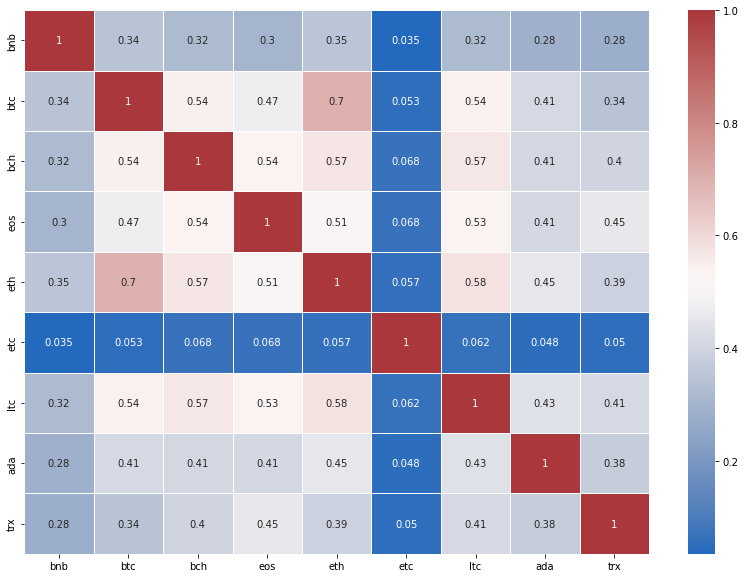

In [15]:
# volume correlation
plt.figure(figsize=(14, 10))
sns.heatmap(volume_agg.corr(method='pearson'),  
            cmap='vlag', 
            annot=True, 
            linewidth=0.5)

In [16]:
# target correlation
target_agg.corr(method='pearson')

,bnb,btc,bch,eos,eth,etc,ltc,ada,trx
bnb,1.000000,-0.039445,0.046235,-0.056934,-0.068263,-0.020567,-0.050308,0.105387,0.025011
btc,-0.039445,1.000000,-0.047830,-0.037317,0.109085,-0.121316,0.044487,-0.131269,-0.056195
bch,0.046235,-0.047830,1.000000,0.049118,-0.050182,0.002560,0.046479,-0.010171,-0.006144
eos,-0.056934,-0.037317,0.049118,1.000000,0.026180,-0.003796,0.114204,-0.024323,0.075586
eth,-0.068263,0.109085,-0.050182,0.026180,1.000000,-0.119004,0.061126,-0.109913,-0.034590
etc,-0.020567,-0.121316,0.002560,-0.003796,-0.119004,1.000000,-0.045844,0.005753,-0.002633
ltc,-0.050308,0.044487,0.046479,0.114204,0.061126,-0.045844,1.000000,-0.060409,-0.001888
ada,0.105387,-0.131269,-0.010171,-0.024323,-0.109913,0.005753,-0.060409,1.000000,0.080310
trx,0.025011,-0.056195,-0.006144,0.075586,-0.034590,-0.002633,-0.001888,0.080310,1.000000


<AxesSubplot:>

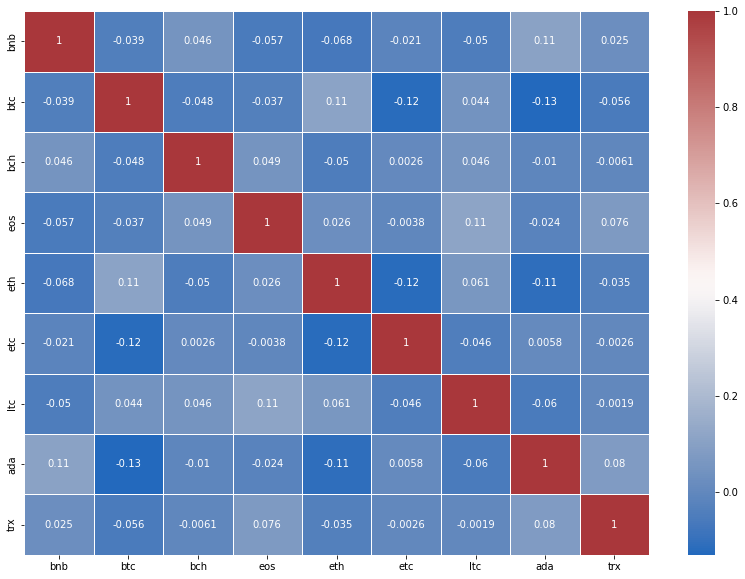

In [17]:
# target correlation
plt.figure(figsize=(14, 10))
sns.heatmap(target_agg.corr(method='pearson'),  
            cmap='vlag', 
            annot=True, 
            linewidth=0.5)

In [18]:
# export to csv
bnb.to_csv(data_folder + 'bnb.csv', index=True)
btc.to_csv(data_folder + 'btc.csv', index=True)
bch.to_csv(data_folder + 'bch.csv', index=True)
eos.to_csv(data_folder + 'eos.csv', index=True)
eth.to_csv(data_folder + 'eth.csv', index=True)
etc.to_csv(data_folder + 'etc.csv', index=True)
ltc.to_csv(data_folder + 'ltc.csv', index=True)
ada.to_csv(data_folder + 'ada.csv', index=True)
trx.to_csv(data_folder + 'trx.csv', index=True)

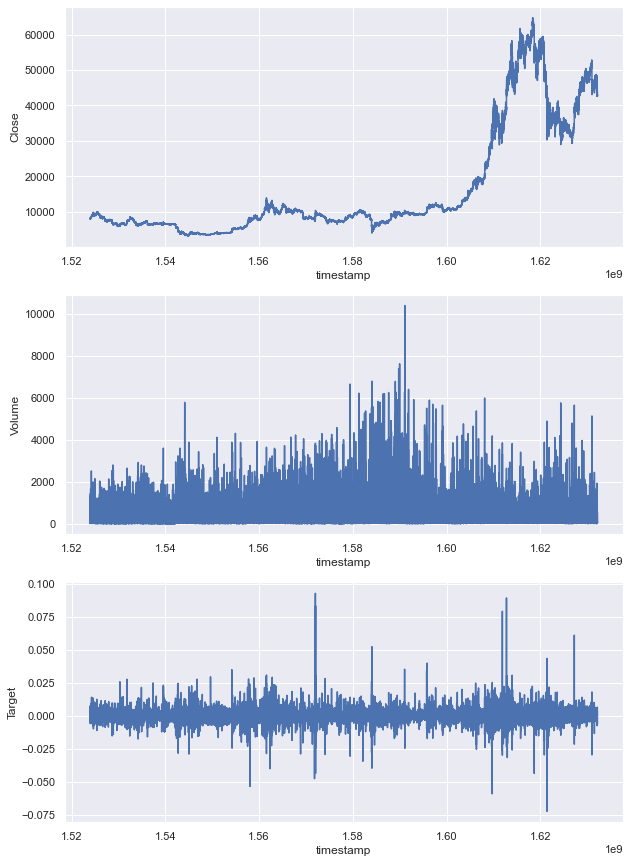

In [27]:
# general graphs show trend of bnb
bnb = bnb.reset_index()
fig, axss = plt.subplots(3, figsize=[10, 15])
sns.set_theme(style="darkgrid")
fig1 = sns.lineplot(x='timestamp', y='Close', data=bnb, ax=axss[0])
fig2 = sns.lineplot(x='timestamp', y='Volume', data=bnb, ax=axss[1])
fig3 = sns.lineplot(x='timestamp', y='Target', data=bnb, ax=axss[2])

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
    df - dataframe with timeseries
    column_name - name of column to analyze (choose 1 at a time)
    window - rolling window size 
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies 

    """

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "red", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(
            series[window:], rolling_mean[window:]
        )
        
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(b=True)

def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=(15, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), color="orange", label="Alpha {}".format(alpha))
    plt.plot(series.values, "b", label = "Actual")
    plt.title("Exponential Smoothing")
    plt.legend(loc="best")
    plt.axis('tight')
    
    if plot_intervals:
        mae = mean_absolute_error(
            series, exponential_smoothing(series, alpha)
        )
        
        deviation = np.std(series - exponential_smoothing(series, alpha))
        lower_bound = exponential_smoothing(series, alpha) - (mae + scale * deviation)
        upper_bound = exponential_smoothing(series, alpha) + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" lower-bound anomalies found"))
            anomalies[series>upper_bound] = series[series>upper_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" upper-bound anomalies found"))
            plt.plot(anomalies, "black", markersize=10)
        
    plt.legend(loc="best")
    plt.grid(b=True)
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    
    with plt.style.context(style):   
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

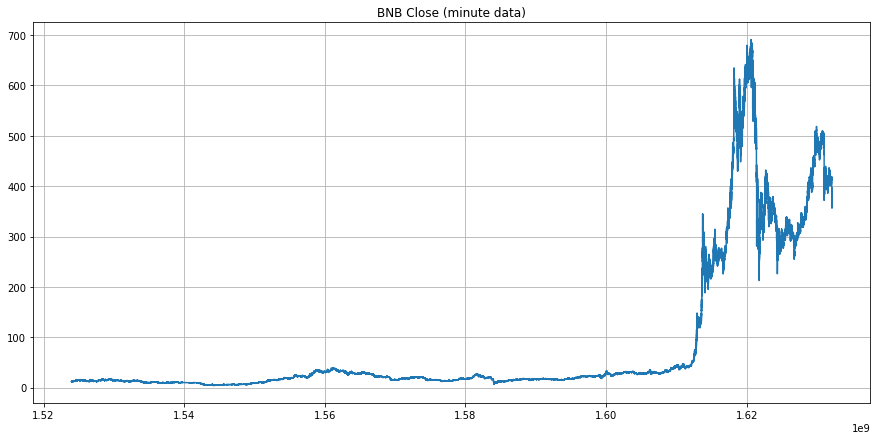

In [20]:
# Plot teturns
plt.figure(figsize=(15, 7))
plt.plot(bnb.Close)
plt.title('BNB Close (minute data)')
plt.grid(True)
plt.show()

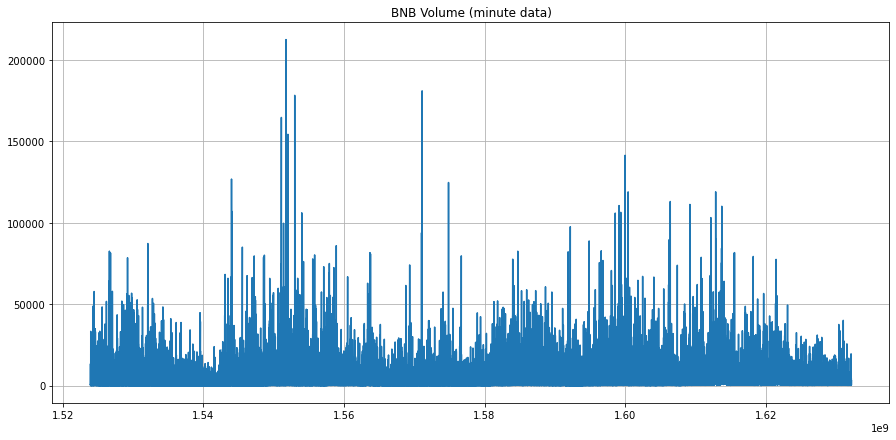

In [21]:
# Plot teturns
plt.figure(figsize=(15, 7))
plt.plot(bnb.Volume)
plt.title('BNB Volume (minute data)')
plt.grid(True)
plt.show()

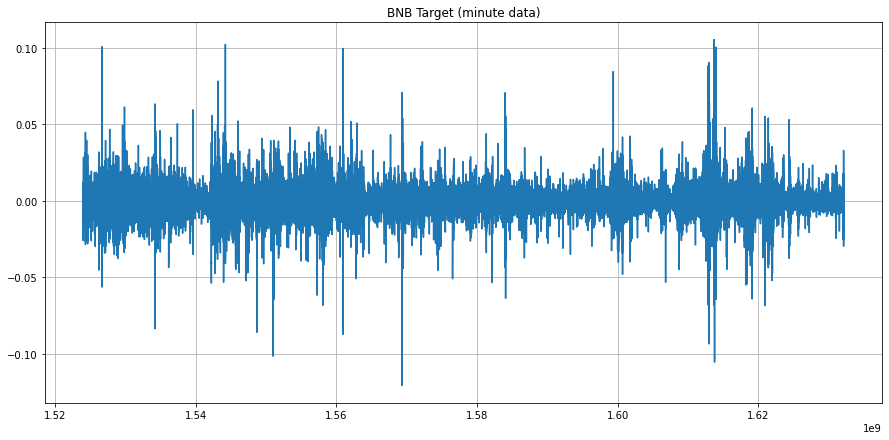

In [22]:
# Plot teturns
plt.figure(figsize=(15, 7))
plt.plot(bnb.Target)
plt.title('BNB Target (minute data)')
plt.grid(True)
plt.show()

In [23]:
# Before moving forward, let's create a shorter version of our dataset for plotting
bnb_mini = bnb.copy()
bnb_mini = bnb_mini.iloc[-500:, :]

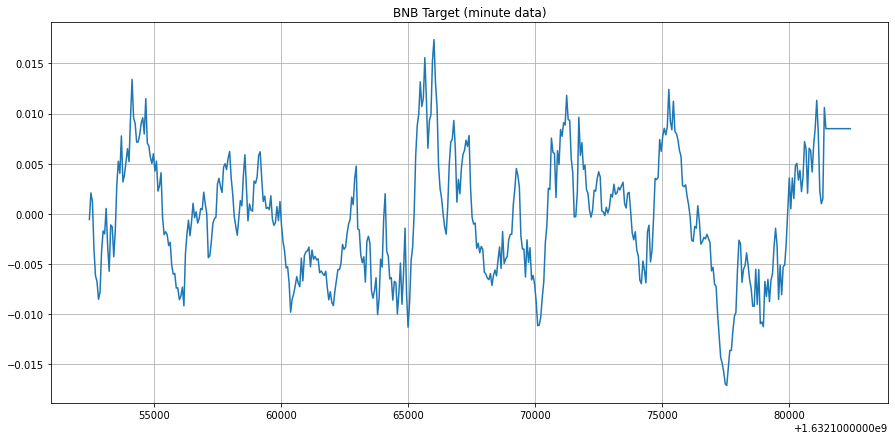

In [24]:
# Plot teturns
plt.figure(figsize=(15, 7))
plt.plot(bnb_mini.Target)
plt.title('BNB Target (minute data)')
plt.grid(True)
plt.show()

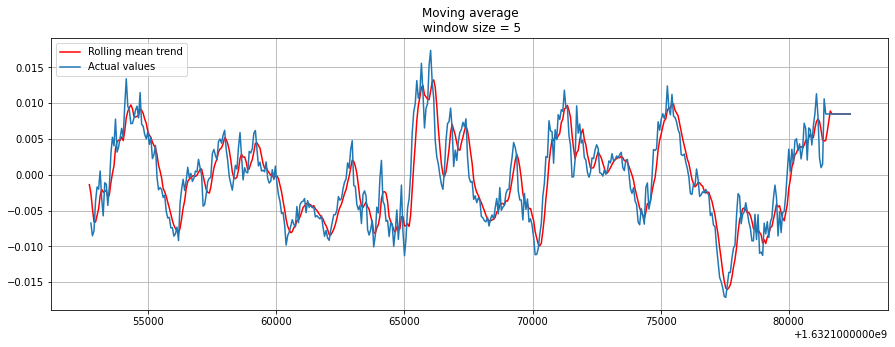

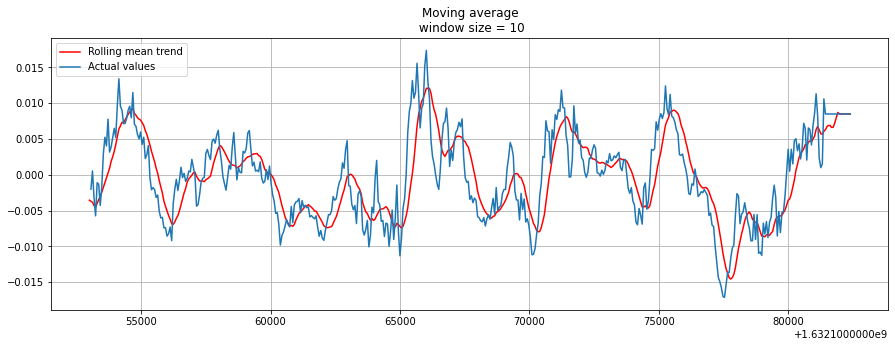

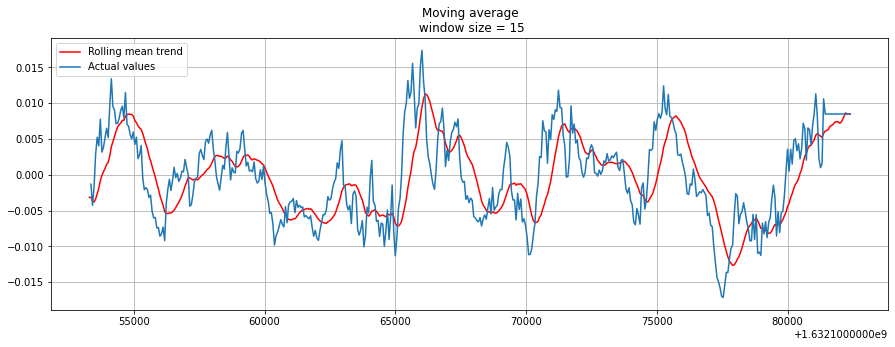

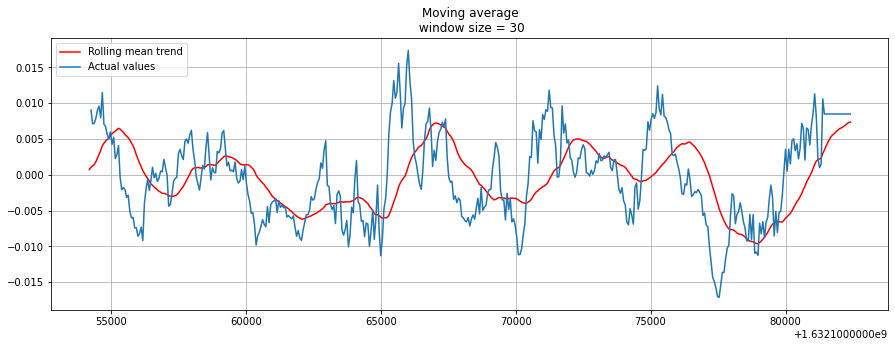

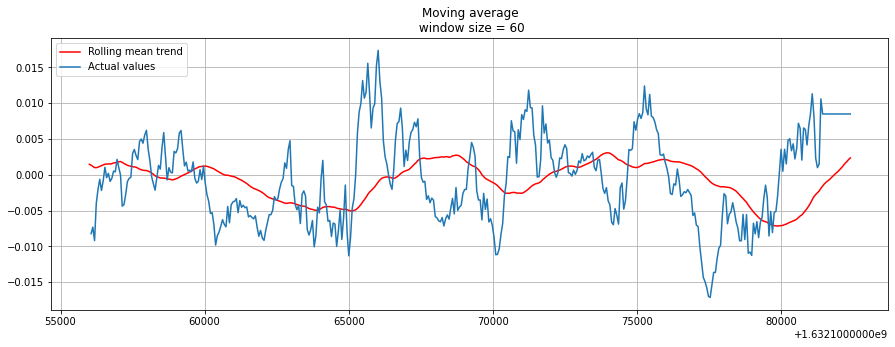

In [25]:
# Let's take a look at several moving averages
windows = [5, 10, 15, 30, 60]
for window in windows:
    plotMovingAverage(bnb_mini.Target, window=window)

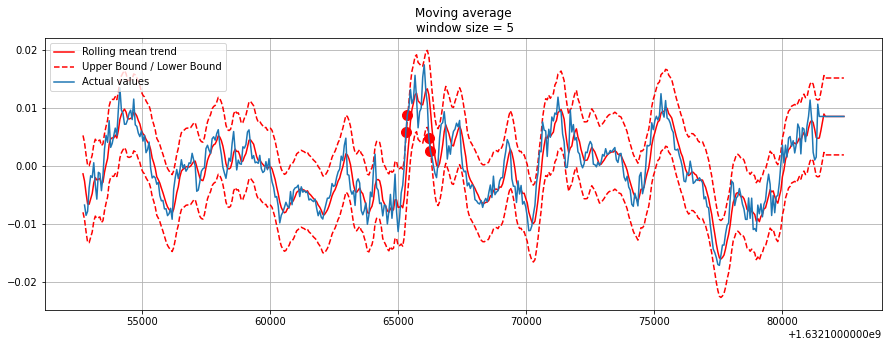

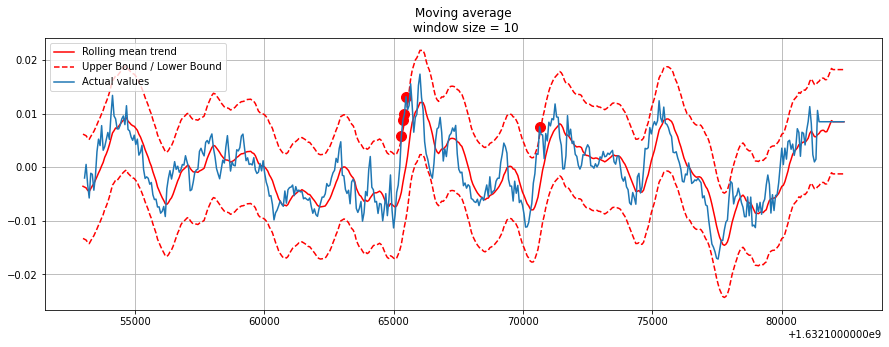

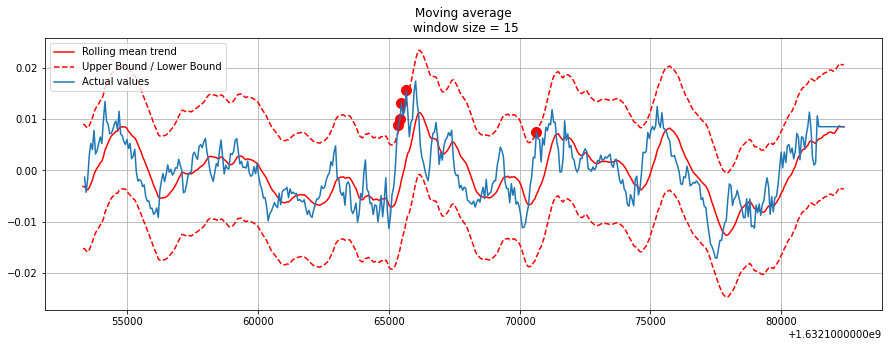

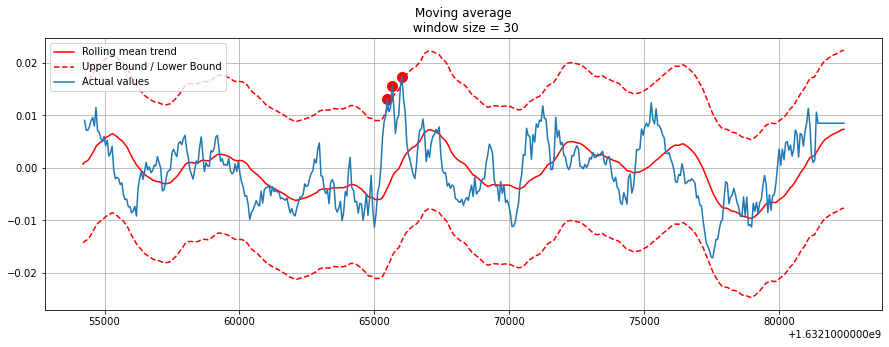

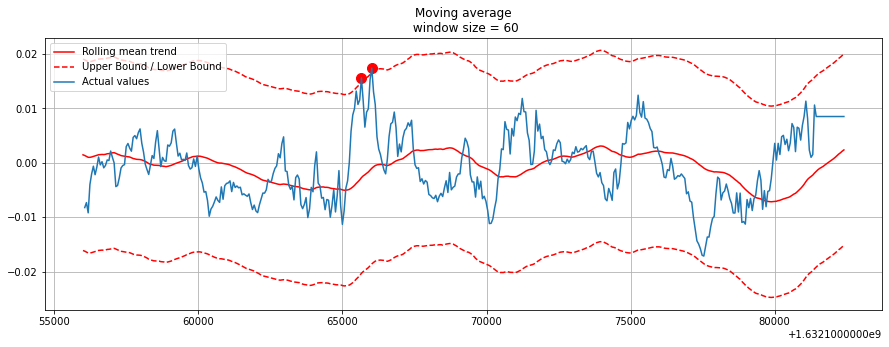

In [26]:
# Now, let's create a simple anomaly detection system with the help of the moving average
import warnings
warnings.filterwarnings('ignore')
windows = [5, 10, 15, 30, 60]
for window in windows:
    plotMovingAverage(bnb_mini.Target, window=window, plot_intervals=True, plot_anomalies=True)

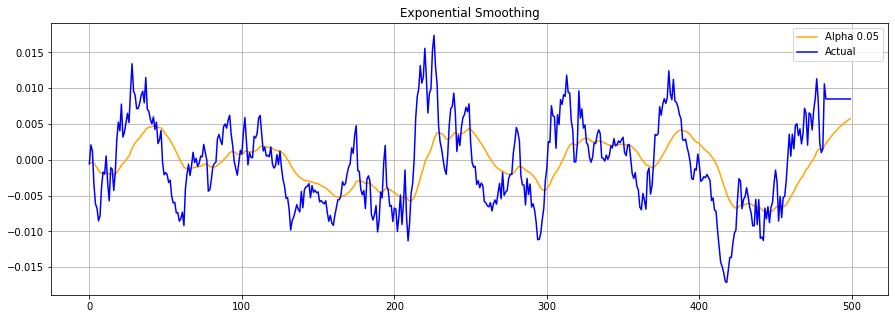

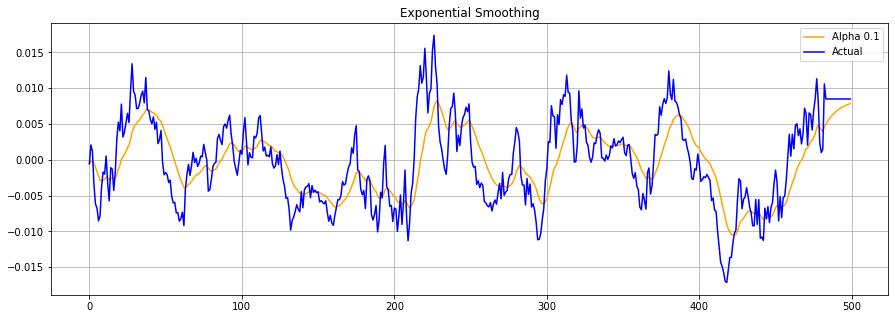

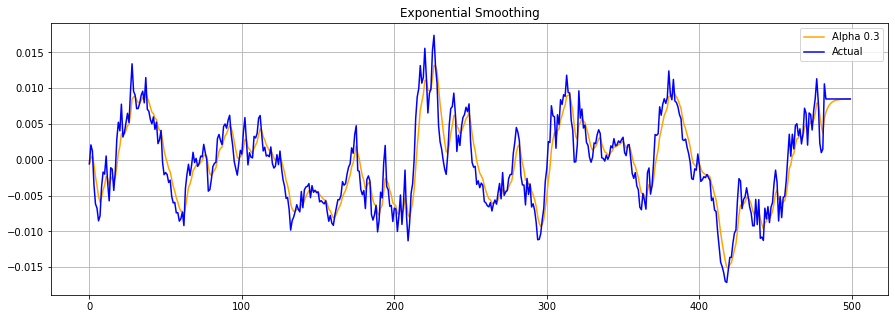

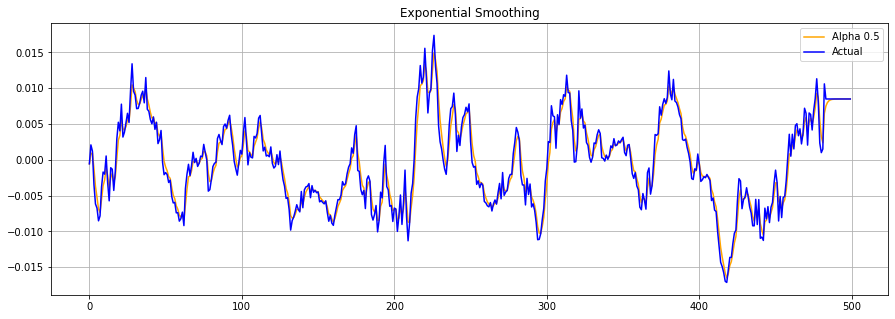

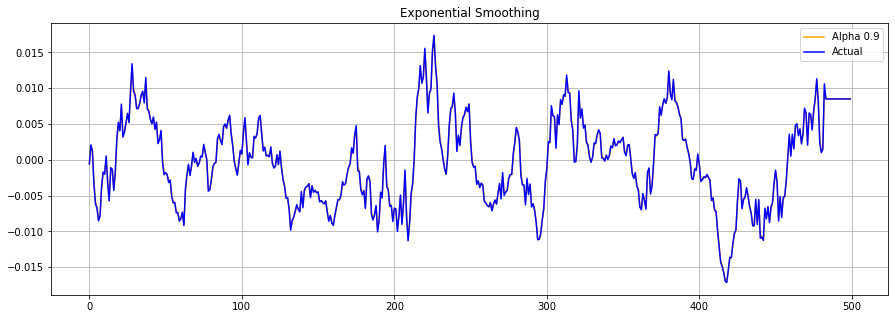

In [27]:
alphas = [.05, .1, .3, .5, .9]
for alpha in alphas:
    plotExponentialSmoothing(bnb_mini.Target, alphas=[alpha])

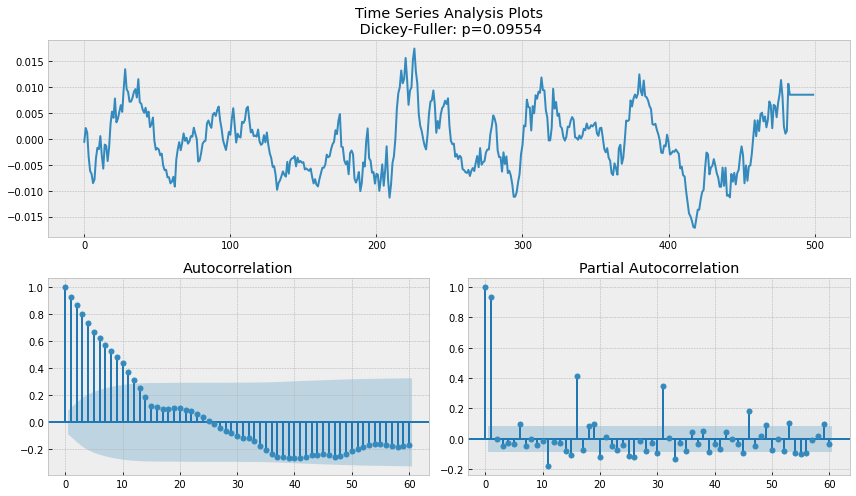

In [28]:
tsplot(bnb_mini.Target.values, lags=60)

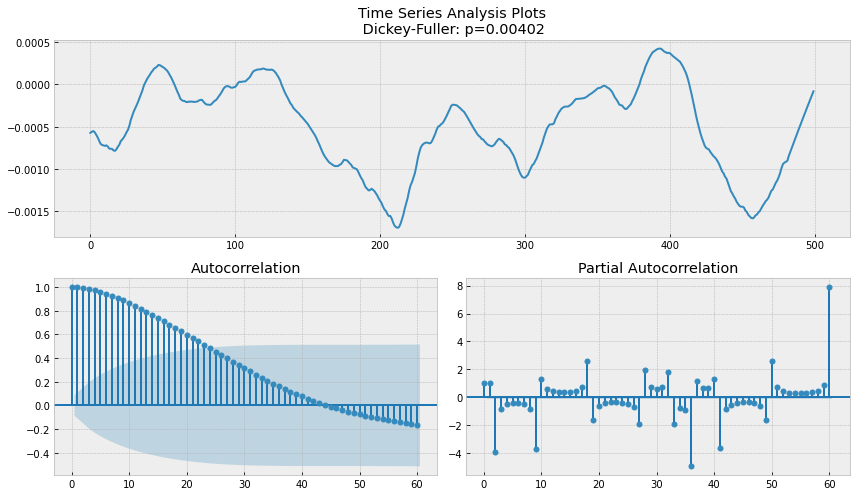

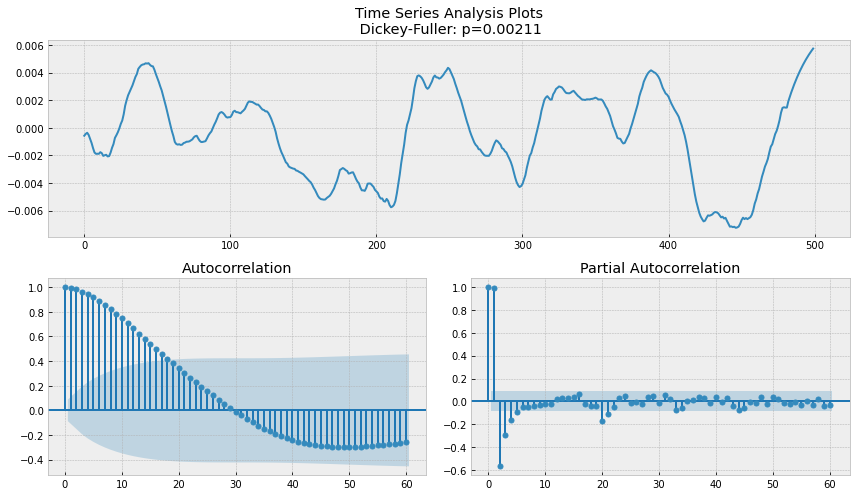

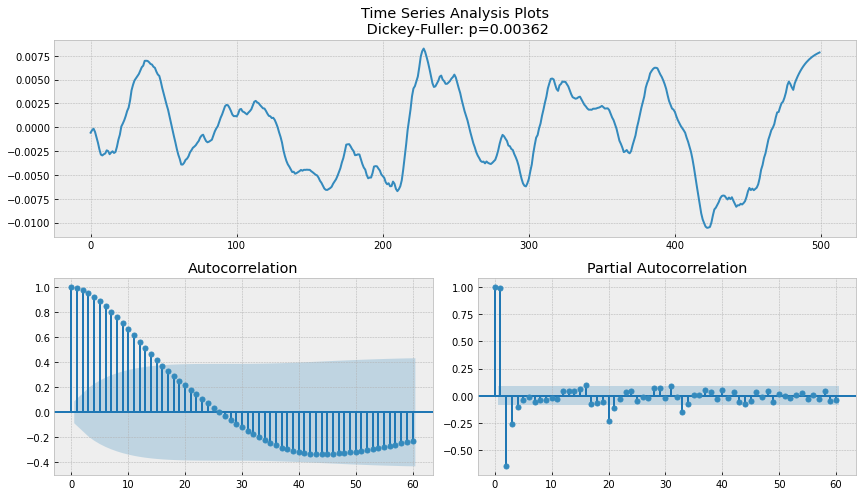

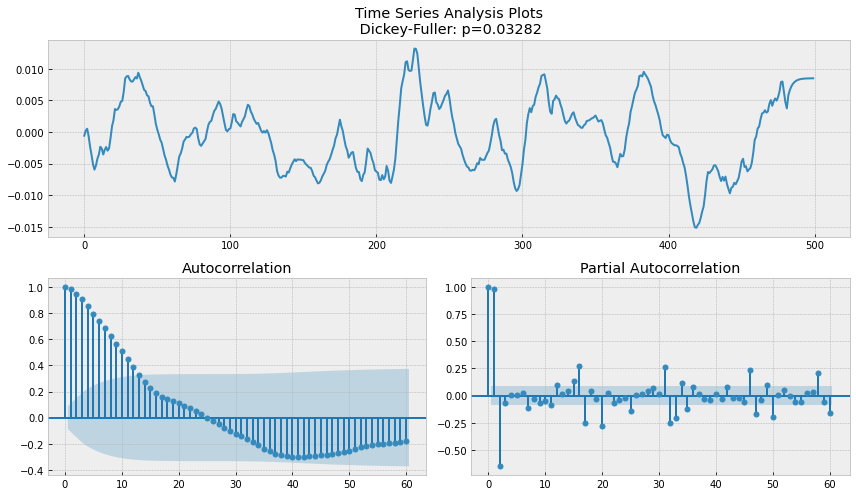

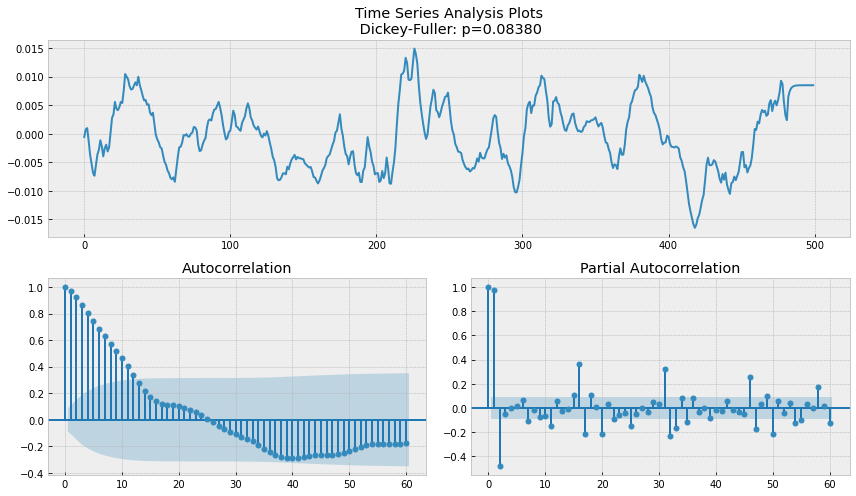

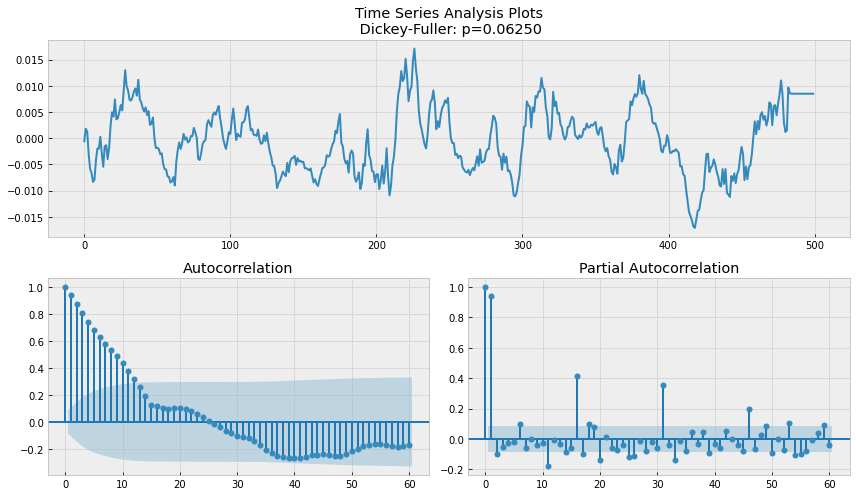

In [29]:
alphas = [.005, .05, .1, .3, .5, .9]
for alpha in alphas:
    current_series = exponential_smoothing(bnb_mini.Target, alpha)
    tsplot(current_series, lags=60)

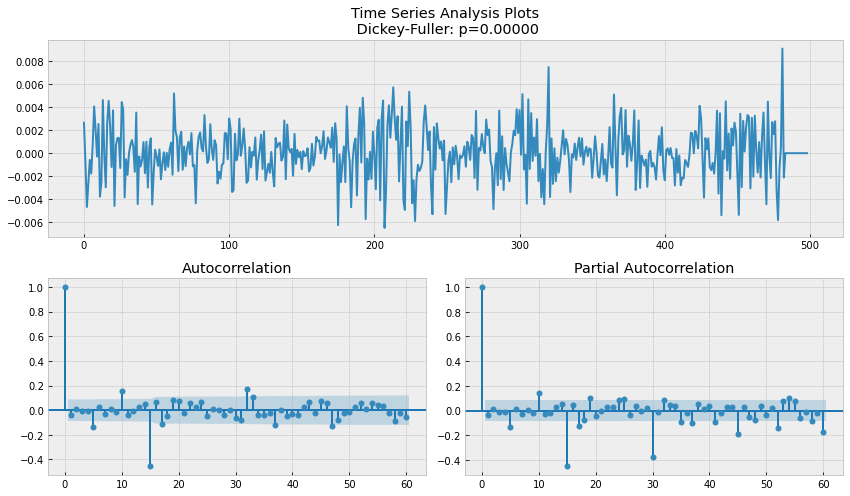

In [30]:
bnb_mini_diff = bnb_mini.Target - bnb_mini.Target.shift(1)
tsplot(bnb_mini_diff[1:].values, lags=60)

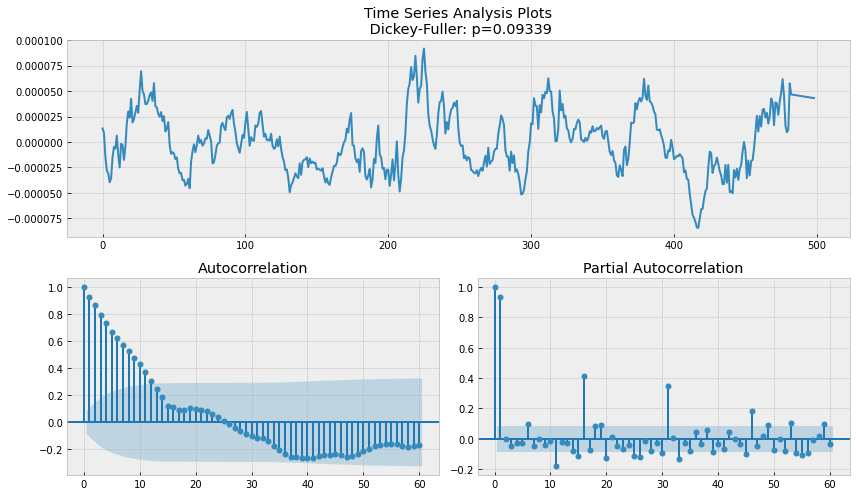

In [54]:
bnb_mini['Target_2'] = exponential_smoothing(bnb_mini.Target, 0.005)
bnb_mini_diff = bnb_mini.Target_2 - bnb_mini.Target_2.shift(1)
tsplot(bnb_mini_diff[1:].values, lags=60)

In [41]:
# bnb = pd.read_csv('bnb.csv') # load data
from tools import FeatureEngineer
bnb = bnb.sample(n=50000, replace=False, random_state=1)
tool = FeatureEngineer()
bnb = tool.build_technical_indicators(bnb) # construct technical indicators
bnb.drop(columns=['Asset_ID', 'KAMA', 'PSAR+', 'PSAR-'], inplace=True) # drop columns with too many NAs
bnb.dropna(axis=0, inplace=True) # drop rows contain missing
r = bnb.index[np.isinf(bnb).any(1)]
bnb.drop([i for i in r], axis=0, inplace=True)

Binance Coin, 0 AIC: -9430.422857839105


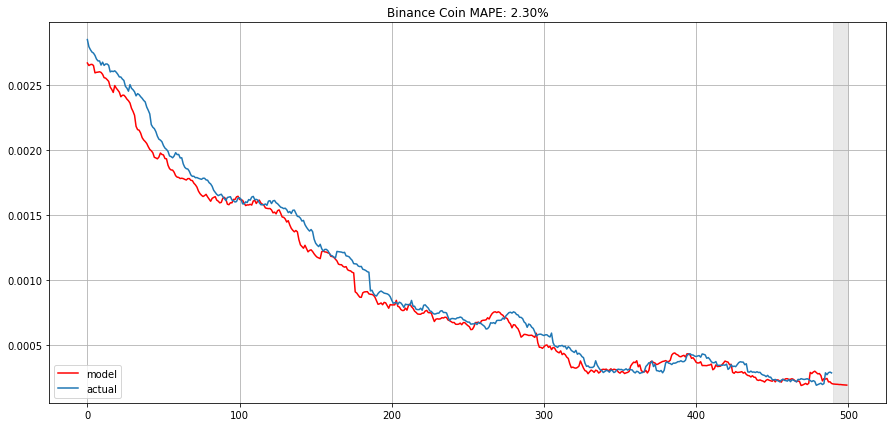

In [56]:
import pickle
n_steps_to_train = 500
n_steps_to_plot = 500
n_steps_to_predict = 10
p = 2
d = 1
q = 10
alpha = 0.005
current_id = 0
current_asset_name = 'Binance Coin'
# suffix = "_train.pickle"
models = dict()
errors = dict()
forecasts = dict()

# # Load individual dataset
# with open(data_folder + current_asset_name + suffix, "rb") as f:
#     current_dataset = pickle.load(f)
current_dataset = bnb.copy()
# Calculate exponential smoothing
current_dataset_mini = current_dataset.copy()[-n_steps_to_train:]
current_dataset_mini["Smoothed"] = exponential_smoothing(current_dataset_mini.Target, alpha=alpha)
data = current_dataset_mini["Smoothed"]

# Train our model
model = statsmodels.tsa.arima.model.ARIMA(endog=data.values, exog=None, order=(p,d,q)).fit() 
aic = model.aic
print(f"{current_asset_name}, {current_id} AIC: {aic}")

# Forecasting
actual = np.array(data.values)
arima_model = np.array(model.fittedvalues)
forecast = list(model.predict(start = len(actual), end = len(actual)+n_steps_to_predict))
forecast = list(arima_model) + forecast

# Save feedback
forecasts[current_id] = forecast
models[current_id] = model
errors[current_id] = mean_absolute_percentage_error(actual, arima_model)

# Save model
with open(f"./models/{current_id}.pickle", "wb") as f:
    pickle.dump(model, f, protocol=4)

# Plot results 
plt.figure(figsize=(15, 7))
plt.title(f"{current_asset_name} MAPE: {errors[current_id]:.2f}%")
plt.plot(forecast[-n_steps_to_plot:], color='r', label="model")
plt.axvspan(len(forecast[-n_steps_to_plot:])-n_steps_to_predict, len(forecast[-n_steps_to_plot:]), alpha=0.5, color='lightgrey')
plt.plot(actual[-n_steps_to_plot:-n_steps_to_predict], label="actual")
plt.legend()
plt.grid(True);